#  AE 238 Plane Truss Analysis

All physical systems follow an optimisation for stored **(potential)** energy minimisation. A struss under load takes a configuration that minimises the potential energy. We can use finite element analysis ,**FEM** , solve this optimisation problem. A hanging rop between two points , which is an infinite dimentional optimisation problem , can be approximated as made of sticks joined together, and reduce the problem to finite dimentional optimisation problem 

## Normal Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dim = 2
L = 1.0

joints = np.array([
    [0.0, 0.0],
    [L, 0.0],
    [0.0, L]
])

members = np.array([
    [0, 1],
    [1, 2],
    [0, 2]
], dtype=int)

n_joints = len(joints)
n_members = len(members)
n_dofs = dim*n_joints

E = 2.1e11 # Pa
Es = E*np.ones(n_members)

A = 1e-4 # m^2
As = A*np.ones(n_members)

def dist(coords1, coords2):
    return np.sqrt(np.sum((coords2 - coords1)**2))

def angle(coords1, coords2):
    L = dist(coords1, coords2)
    dx = coords2[0] - coords1[0]
    return np.arccos(dx/L)

def member_stiffness(coords1, coords2, E, A):
    K = np.zeros((4, 4))
    L = dist(coords1, coords2)
    theta = angle(coords1, coords2)
    c = np.cos(theta)
    s = np.sin(theta)

    K[0, 0] = c*c
    K[0, 1] = c*s
    K[0, 2] = -c*c
    K[0, 3] = -c*s
    
    K[1, 0] = c*s
    K[1, 1] = s*s
    K[1, 2] = -c*s
    K[1, 3] = -s*s

    K[2, 0] = -c*c
    K[2, 1] = -c*s
    K[2, 2] = c*c
    K[2, 3] = c*s

    K[3, 0] = -c*s
    K[3, 1] = -s*s
    K[3, 2] = c*s
    K[3, 3] = s*s

    return E*A*K/L


In [3]:
K = np.zeros((n_dofs, n_dofs))
for i in range(n_members):
    id1, id2 = members[i]
    K_member = member_stiffness(joints[id1], joints[id2], Es[i], As[i])

    ids = []
    ids.append(2*id1)
    ids.append(2*id1 + 1)
    ids.append(2*id2)
    ids.append(2*id2 + 1)

    for j in range(4):
        for k in range(4):
            K[ids[j], ids[k]] += K_member[j, k]

In [4]:
P = 1e4
Q = 1e4

In [5]:
F = np.zeros(n_dofs)
F[2*1 + 1] = Q
F[2*1 + 0] = P

In [6]:
dofs = np.array([np.nan for _ in range(n_dofs)])
dofs[2*0 + 0] = 0.0
dofs[2*0 + 1] = 0.0
dofs[2*2 + 0] = 0.0
dofs[2*2 + 1] = 0.0

In [7]:
n_support = 0
K_support = []
for i in range(n_dofs):
    if not np.isnan(dofs[i]):
        n_support += 1
        K_support.append(np.array(K[i]))
        for j in range(n_dofs):
            if j == i:
                K[i, j] = 1.0
            else:
                K[i, j] = 0.0

dofs = np.linalg.solve(K, F)

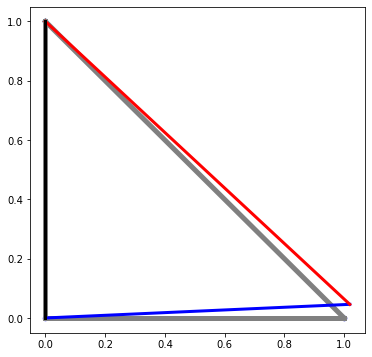

In [8]:
reactions = np.zeros(n_support)
for i in range(n_support):
    reactions[i] = K_support[i] @ dofs

member_forces = np.zeros(n_members)
for i in range(n_members):
    id1, id2 = members[i]
    u1 = dofs[2*id1 + 0]
    v1 = dofs[2*id1 + 1]
    u2 = dofs[2*id2 + 0]
    v2 = dofs[2*id2 + 1]
    theta = angle(joints[id1], joints[id2])
    L = dist(joints[id1], joints[id2])
    d1 = u1*np.cos(theta) + v1*np.sin(theta)
    d2 = u2*np.cos(theta) + v2*np.sin(theta)
    member_forces[i] = Es[i]*As[i]*(d2 - d1)/L

def plot_plane_truss(joints, members, member_forces=None, dofs=None, mag=2e1):
    TOL = 1e-6
    fig = plt.figure(figsize=(6, 6))

    for i in range(n_members):
        id1, id2 = members[i]
        plt.plot(
            [joints[id1, 0], joints[id2, 0]],
            [joints[id1, 1], joints[id2, 1]],
            '-', color='gray', linewidth=5)

    plt.scatter(joints[:, 0], joints[:, 1], c='b', s=20)

    for i in range(n_members):
        id1, id2 = members[i]
        x1 = joints[id1, 0] + mag*dofs[2*id1 + 0]
        y1 = joints[id1, 1] + mag*dofs[2*id1 + 1]
        x2 = joints[id2, 0] + mag*dofs[2*id2 + 0]
        y2 = joints[id2, 1] + mag*dofs[2*id2 + 1]

        color = 'black'
        if member_forces[i] > TOL:
            color = 'blue'
        elif member_forces[i] < -TOL:
            color = 'red'

        plt.plot(
            [x1, x2], [y1, y2],
            '-', color=color, linewidth=3)

    plt.show()

plot_plane_truss(joints, members, member_forces, dofs)


## Class / Object based coding approach

In [9]:
"""
simple truss example libraby way
"""
import numpy as np
import plane_truss_lib as amu

In [10]:
L=1
joints = np.array([[0.0,0.0],[L,0.0],[0.0,L]])

In [11]:
members = np.array([[0,1],[1,2],[0,2]],dtype= int)

In [12]:
E=2.1e11
A=1e-4

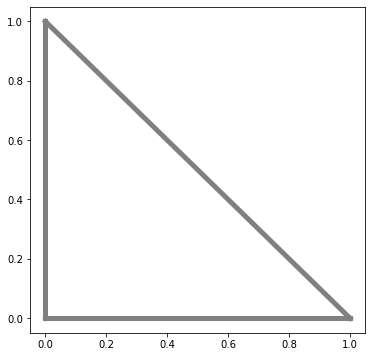

In [13]:
truss = amu.PlaneTruss(joints, members, E, A)
truss.plot(deformed=False) #reality check

In [14]:
constraints = [
        [0, 0, 0.0], #node 0 , directon 0 displacement =0.0
        [0, 1, 0.0], #node 0 , direction 1 disp =0.0
        [2, 0, 0.0], #node 2 direction 0 disp =0.0 
        [2, 1, 0.0]  #node 2 , direction 1 dispacement =0.0
    ]

In [15]:
truss.apply_constraints(constraints)

In [16]:
P = -1e4
Q = 3e4
loads = [
        [1, 0, P], #node 1 , direction 0 force P
        [1, 1, Q]  #node 1 , direction 1 force Q
    ]
truss.apply_loads(loads)


In [17]:
truss.solve()

In [18]:
truss.dofs #displacement of joints

array([-2.32171368e-19,  0.00000000e+00,  9.52380952e-04,  4.99299113e-03,
        0.00000000e+00,  0.00000000e+00])

In [19]:
truss.member_forces

array([ 2.00000000e+04, -4.24264069e+04,  2.98544319e-28])

In [20]:
truss.reactions

array([-2.00000000e+04, -2.98544319e-28,  3.00000000e+04, -3.00000000e+04])

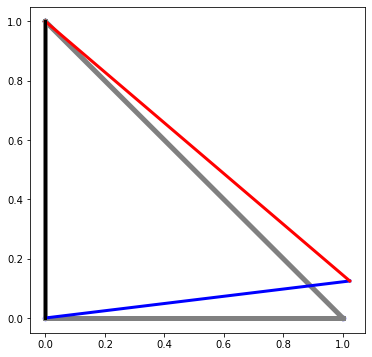

In [21]:
truss.plot()

In [35]:
A = np.array([[2,3,4],[1,2,3],[4,9,72/5]])

In [36]:
k = np.array([1/2,1/6,1/2])

In [41]:
B= np.linalg.solve(A, k)

In [42]:
B + 0

array([ 5.00000000e-01, -1.66666667e-01,  1.04083409e-16])